In [1]:
import glob
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

In [2]:
# algorithms = ['gemm', 'igemm', 'ipgemm', 'fft', 'fftt', 'wino']
algorithms = ['gemm', 'igemm', 'ipgemm', 'fft', 'wino']
features = ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw']

configs = pd.read_csv('./search_space/regnet_convs_unique.csv')
train_cfg_strs = []
test_cfg_strs = []
for i, row in configs.iterrows():
    cfg_str = '_'.join([str(int(row[k])) for k in features])
    if i < 4000:
        train_cfg_strs.append(cfg_str)
    else:
        test_cfg_strs.append(cfg_str)

In [3]:
def read_log(mode, algo):
    df = pd.read_csv(sorted(glob.glob(f'./logs/{mode}/{algo}-*.csv'))[-1])
    df['algo'] = algorithms.index(algo)
    df['params'] = df['out_channels'] * (np.square(df['kernel_size']) * df['in_channels'] / df['groups'] + 1)
    df['flops'] = np.square(df['hw'] // df['stride'])
    return df

energy_df = pd.concat([read_log('energy', algo) for algo in algorithms], ignore_index=True)
energy_df['test'] = [
    '_'.join([str(int(row[k])) for k in features]) in test_cfg_strs
    for i, row in energy_df.iterrows()
]
latency_df = pd.concat([read_log('latency', algo) for algo in algorithms], ignore_index=True)

print(f'Energy entries: {len(energy_df)} / Latency entries: {len(latency_df)} ')
# features = features + ['params', 'flops']

energy_df

Energy entries: 18181 / Latency entries: 96900 


,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,sample_num,gpu_sampler,latency,energy,temperature,memory,util,algo,params,flops,test
0,1680,1680,3,1,10,7,7,11122,1,0.000897,0.048413,27.748744,5.461162,71.547739,0,2541840.0,49,False
1,3000,3000,3,2,25,14,7,5200,1,0.001844,0.087597,27.994764,5.461162,79.842932,0,3243000.0,49,False
2,208,52,1,1,1,14,7,38210,1,0.000236,0.008591,27.994444,5.264613,53.561111,0,10868.0,196,False
3,792,792,3,2,11,7,7,20493,1,0.000461,0.017388,27.861702,5.289181,71.792553,0,514008.0,9,False
4,448,448,3,2,4,56,7,5782,1,0.001486,0.088978,28.660819,5.473447,63.111111,0,452032.0,784,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18176,1024,1024,3,1,16,7,2,25502,1,0.000404,0.017930,27.921951,5.313750,42.790244,4,590848.0,49,True
18177,288,288,3,1,6,14,2,31911,1,0.000327,0.013157,28.000000,5.276897,30.309179,4,124704.0,196,True
18178,720,720,3,1,15,14,2,16942,1,0.000563,0.024229,27.952381,5.301466,38.116402,4,311760.0,196,True
18179,2048,2048,3,1,16,28,2,3207,1,0.003488,0.202725,28.761261,5.657712,46.531532,4,2361344.0,784,True


In [4]:
def calc_rmse(y, pred):
    return np.sqrt(np.mean(np.square(y - pred)))

def calc_err(y, pred):
    return np.abs(y - pred) / y

def calc_acc(err, r):
    return sum(err <= r) / len(err) * 100

def evaluate(model, X, y, exp2=True):
    pred = model.predict(X)
    if exp2:
        y = np.exp2(y)
        pred = np.exp2(pred)
    err = calc_err(y, pred)
    results = [calc_acc(err, 0.05), calc_acc(err, 0.1), calc_acc(err, 0.15), calc_rmse(y, pred)]
    print("5%% : %2.2f%% | 10%% : %2.2f%% | 15%% : %2.2f%% | RMSE : %1.5f" % tuple(results))
    return results

In [5]:
def calc_grid_size(df, algo):
    # Explicit Gemm
    channels = df['out_channels']
    channel_scale = np.ceil(np.array(channels) / 128)
    hw_scale = np.ceil(np.square(df['hw'] / df['stride']) / 64)
    grid_size = (channel_scale * hw_scale).astype(np.int32)
    df['grid_size'] = grid_size

calc_grid_size(energy_df, 'gemm')
calc_grid_size(latency_df, 'gemm')
energy_df

,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,sample_num,gpu_sampler,latency,energy,temperature,memory,util,algo,params,flops,test,grid_size
0,1680,1680,3,1,10,7,7,11122,1,0.000897,0.048413,27.748744,5.461162,71.547739,0,2541840.0,49,False,14
1,3000,3000,3,2,25,14,7,5200,1,0.001844,0.087597,27.994764,5.461162,79.842932,0,3243000.0,49,False,24
2,208,52,1,1,1,14,7,38210,1,0.000236,0.008591,27.994444,5.264613,53.561111,0,10868.0,196,False,4
3,792,792,3,2,11,7,7,20493,1,0.000461,0.017388,27.861702,5.289181,71.792553,0,514008.0,9,False,7
4,448,448,3,2,4,56,7,5782,1,0.001486,0.088978,28.660819,5.473447,63.111111,0,452032.0,784,False,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18176,1024,1024,3,1,16,7,2,25502,1,0.000404,0.017930,27.921951,5.313750,42.790244,4,590848.0,49,True,8
18177,288,288,3,1,6,14,2,31911,1,0.000327,0.013157,28.000000,5.276897,30.309179,4,124704.0,196,True,12
18178,720,720,3,1,15,14,2,16942,1,0.000563,0.024229,27.952381,5.301466,38.116402,4,311760.0,196,True,24
18179,2048,2048,3,1,16,28,2,3207,1,0.003488,0.202725,28.761261,5.657712,46.531532,4,2361344.0,784,True,208


In [6]:
best_params = {'eta': 0.2, 'gamma': 0.001, 'n_estimators': 100, 'max_depth': 10, 'min_child_weight': 0}

# latency_input_features = features + ['algo', 'grid_size']
latency_input_features = features + ['algo']
# latency_input_features = features

train_X, train_y = latency_df[latency_input_features], latency_df['latency']
train_y = np.log2(train_y)

xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
xgb_r.fit(train_X, train_y)
test_X, test_y = energy_df[latency_input_features], energy_df['latency']
test_y = np.log2(test_y)
print(f'Train set shape: {len(train_y)}')
acc_train = evaluate(xgb_r, train_X, train_y)
print(f'Test set shape: {len(test_y)}')
acc_test = evaluate(xgb_r, test_X, test_y)
latency_hat = xgb_r.predict(test_X)
latency_hat = np.exp2(latency_hat)
energy_df['latency_hat'] = latency_hat

# energy_df['latency_hat'] = 0
# for algo in range(len(algorithms)):
#     algo_filter = latency_df['algo'] == algo
#     algo_train_X = train_X[algo_filter]
#     algo_train_y = train_y[algo_filter]
#     cut = int(len(algo_train_y) * 0.8)
#     algo_val_X = algo_train_X.iloc[cut:, :]
#     algo_train_X = algo_train_X.iloc[:cut, :]
#     algo_val_y = algo_train_y.iloc[cut:]
#     algo_train_y = algo_train_y.iloc[:cut]
#     print(f'[{algorithms[algo]}] Train set shape: {len(algo_train_y)}')
#     xgb_r = xgb.XGBRegressor(seed=2022, n_estimators=100, **best_params)
#     xgb_r.fit(algo_train_X, algo_train_y)
#     acc_train = evaluate(xgb_r, algo_train_X, algo_train_y)
#     algo_filter = energy_df['algo'] == algo
#     algo_test_X = energy_df[algo_filter][latency_input_features]
#     algo_test_y = energy_df[algo_filter]['latency']
#     algo_test_y = np.log2(algo_test_y)
#     print(f'[{algorithms[algo]}] Val set shape: {len(algo_val_y)}')
#     acc_test = evaluate(xgb_r, algo_val_X, algo_val_y)
#     print(f'[{algorithms[algo]}] Test set shape: {len(algo_test_y)}')
#     acc_test = evaluate(xgb_r, algo_test_X, algo_test_y)
#     latency_hat = xgb_r.predict(algo_test_X)
#     latency_hat = np.exp2(latency_hat)
#     energy_df.loc[algo_filter, 'latency_hat'] = latency_hat

energy_df

Train set shape: 96900
5% : 40.07% | 10% : 70.40% | 15% : 87.54% | RMSE : 0.00038
Test set shape: 18181
5% : 34.28% | 10% : 60.07% | 15% : 76.49% | RMSE : 0.00051


,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,sample_num,gpu_sampler,latency,energy,temperature,memory,util,algo,params,flops,test,grid_size,latency_hat
0,1680,1680,3,1,10,7,7,11122,1,0.000897,0.048413,27.748744,5.461162,71.547739,0,2541840.0,49,False,14,0.000794
1,3000,3000,3,2,25,14,7,5200,1,0.001844,0.087597,27.994764,5.461162,79.842932,0,3243000.0,49,False,24,0.001868
2,208,52,1,1,1,14,7,38210,1,0.000236,0.008591,27.994444,5.264613,53.561111,0,10868.0,196,False,4,0.000290
3,792,792,3,2,11,7,7,20493,1,0.000461,0.017388,27.861702,5.289181,71.792553,0,514008.0,9,False,7,0.000561
4,448,448,3,2,4,56,7,5782,1,0.001486,0.088978,28.660819,5.473447,63.111111,0,452032.0,784,False,52,0.001657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18176,1024,1024,3,1,16,7,2,25502,1,0.000404,0.017930,27.921951,5.313750,42.790244,4,590848.0,49,True,8,0.000431
18177,288,288,3,1,6,14,2,31911,1,0.000327,0.013157,28.000000,5.276897,30.309179,4,124704.0,196,True,12,0.000366
18178,720,720,3,1,15,14,2,16942,1,0.000563,0.024229,27.952381,5.301466,38.116402,4,311760.0,196,True,24,0.000595
18179,2048,2048,3,1,16,28,2,3207,1,0.003488,0.202725,28.761261,5.657712,46.531532,4,2361344.0,784,True,208,0.003669


In [7]:
best_params = {'eta': 0.2, 'gamma': 0.001, 'n_estimators': 100, 'max_depth': 10, 'min_child_weight': 0}

accs = []
for all_features in [
    features + ['algo'],
    features + ['algo', 'latency'],
    # features + ['algo', 'grid_size'],
    features + ['algo', 'latency', 'grid_size'],
]:
    print(f'Features: {all_features}')
    X, y = energy_df[all_features], energy_df['energy']
    y = np.log2(y)
    train_X = X[energy_df['test'] == False]
    train_y = y[energy_df['test'] == False]
    print(f'Training set shape: {len(train_y)}')
    xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
    xgb_r.fit(train_X, train_y)
    acc_train = evaluate(xgb_r, train_X, train_y)
    for algo in range(len(algorithms)):
        # algo_filter = (energy_df['test'] == False) & (energy_df['algo'] == algo)
        # train_X = X[algo_filter]
        # train_y = y[algo_filter]
        # print(f'[{algorithms[algo]}] Training set shape: {len(train_y)}')
        # xgb_r = xgb.XGBRegressor(seed=2022, **best_params)
        # xgb_r.fit(train_X, train_y)
        algo_filter = (energy_df['test'] == True) & (energy_df['algo'] == algo)
        test_X = X[algo_filter]
        if 'latency' in all_features:
            test_X = test_X.copy()
            test_X['latency'] = energy_df[algo_filter]['latency_hat']
        test_y = y[algo_filter]
        print(f'[{algorithms[algo]}] Test set shape: {len(test_y)}')
        accs.append(evaluate(xgb_r, test_X, test_y))

accs = np.array(accs).reshape((3, len(algorithms), -1))

Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'algo']
Training set shape: 15092
5% : 68.91% | 10% : 88.37% | 15% : 94.71% | RMSE : 0.00967
[gemm] Test set shape: 823
5% : 23.94% | 10% : 45.44% | 15% : 61.12% | RMSE : 0.03131
[igemm] Test set shape: 823
5% : 28.31% | 10% : 48.60% | 15% : 65.01% | RMSE : 0.03319
[ipgemm] Test set shape: 823
5% : 24.42% | 10% : 43.99% | 15% : 58.20% | RMSE : 0.05446
[fft] Test set shape: 413
5% : 55.21% | 10% : 83.78% | 15% : 91.77% | RMSE : 0.03329
[wino] Test set shape: 207
5% : 54.59% | 10% : 79.71% | 15% : 94.20% | RMSE : 0.00956
Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'algo', 'latency']
Training set shape: 15092
5% : 87.05% | 10% : 97.93% | 15% : 99.60% | RMSE : 0.00514
[gemm] Test set shape: 823
5% : 21.26% | 10% : 39.25% | 15% : 58.20% | RMSE : 0.03795
[igemm] Test set shape: 823
5% : 25.15% | 10% : 45.44% | 15% : 62.45% | RMSE : 0.03295
[ipgemm] Test set shape: 823
5% 

Text(0.5, 1.0, 'Energy Predictor Accuracy on P100')

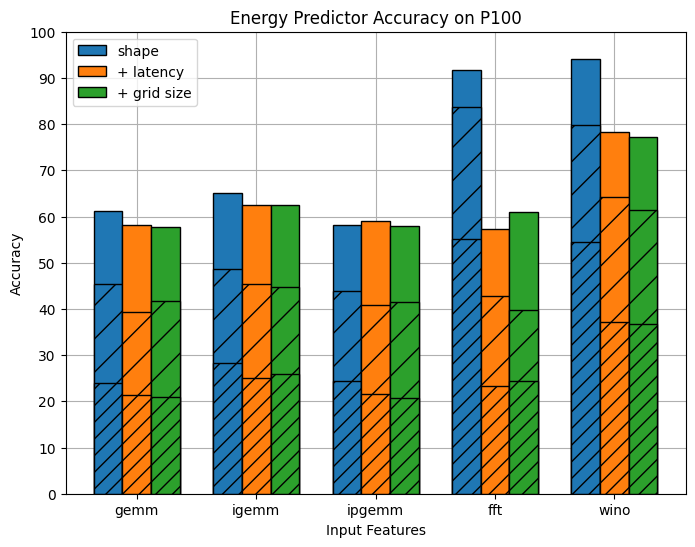

In [8]:
ind = np.arange(len(algorithms))

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

for i, feature_set in enumerate(['shape', '+ latency', '+ grid size']):
    width = 0.24
    ind_shift = ind + (i - 3 // 2) * width
    ax.bar(ind_shift, accs[i, :, 2], hatch='', color=f'C{i}', edgecolor='black', width=width, label=feature_set)
    ax.bar(ind_shift, accs[i, :, 1], hatch='/', color=f'C{i}', edgecolor='black', width=width)
    ax.bar(ind_shift, accs[i, :, 0], hatch='//', color=f'C{i}', edgecolor='black', width=width)

ax.set_xticks(ind, algorithms)
ax.set_yticks(np.arange(11) * 10)
ax.grid()
ax.axis()
ax.set_axisbelow(True)
ax.set_xlabel('Input Features')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Energy Predictor Accuracy on P100')

Text(0.5, 1.0, 'Energy Predictor RMSE on P100')

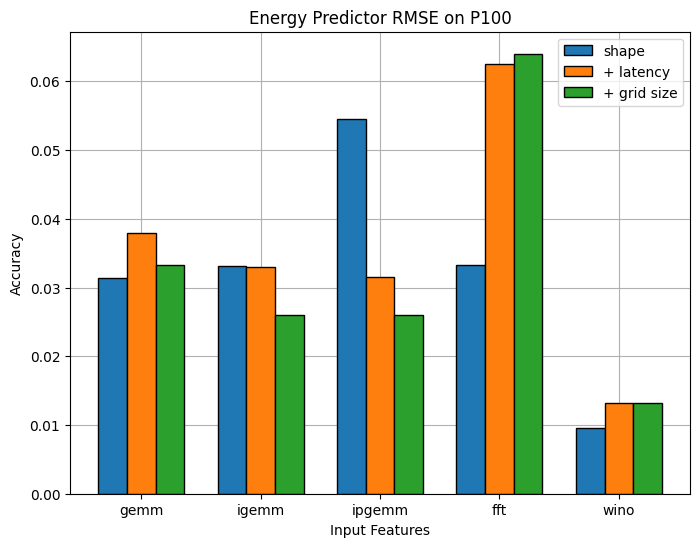

In [9]:
ind = np.arange(len(algorithms))

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

for i, feature_set in enumerate(['shape', '+ latency', '+ grid size']):
    width = 0.24
    ind_shift = ind + (i - 3 // 2) * width
    ax.bar(ind_shift, accs[i, :, 3], hatch='', color=f'C{i}', edgecolor='black', width=width, label=feature_set)

ax.set_xticks(ind, algorithms)
ax.grid()
ax.axis()
ax.set_axisbelow(True)
ax.set_xlabel('Input Features')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Energy Predictor RMSE on P100')